# Visualizing Entanglement

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/introduction/visualizing-entanglement

## Getting to know your qubit

In [18]:
# This line of code shown in the documentation fails here, says module not found
# from hello_qiskit import run_puzzle

Due to maybe old documentation and different package versions, the import of `hello-qiskit` fails. Therefore, I just walked through the interactive "puzzles" on the documentation page directly. However, this section wasn't that helpful.

## Bell's Inequalities

### Bell test for _classical_ variables

First, we'll explore the Bell test for classical variables. We want to first generate a pair of random variables, A and B, and the only rule is that process for generating the randomness is the same for every run.

For example, we'll make A and B be two random floating point numbers that are correlated.

In [37]:
import random
def setup_variables():

    r = random.random() # random value between [0, 1)

    A = r*(2/3)
    B = r*(1/3)

    return A, B

We can take a look at what these variables might look like by sampling this setup process. As shown below, we have a fairly uniform distribution for both but with different ranges: A extends from 0 to 0.66 (evident from the 2/3 factor applied above) whereas B ranges only from 0 to 0.33 (from the 1/2 factor applied above)

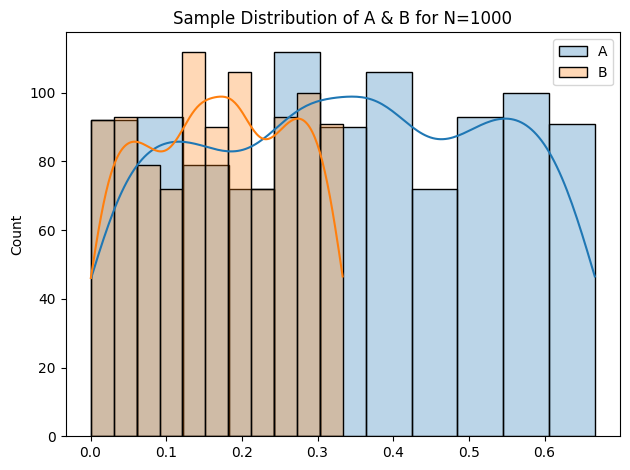

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

samples = np.array([setup_variables() for _ in range(1000)])

fig, ax = plt.subplots()
sns.histplot(samples[:, 0], kde=True, label='A', alpha=0.3, ax=ax)
sns.histplot(samples[:, 1], kde=True, label='B', alpha=0.3, ax=ax)
ax.set_title("Sample Distribution of A & B for N=1000")
plt.legend()
plt.tight_layout()

Next, we want to define a hashing function that can give back 2 different types of hashes. We can do this with a very simple function below that given an input and a hash type (H or V), will give an output hashing bit of 0 or 1 based on the implemented logic.

In [39]:
def hash2bit(variable, hash_type):

    if hash_type == 'V':
        bit = (variable < 0.5)
    elif hash_type == 'H':
        bit = (variable < 0.25)

    bit = str(int(bit))

    return bit

The above hash2bit function is based off bounds/limits. For hash_type V, variable B will never have a bit 0 knowing what we know about the distributions shown above.

However, we want to define 4 quantities:

* P[HH] = probability that hash2bit(A, 'H') != hash2bit(B, 'H')
* P[HV] = probability that hash2bit(A, 'H') != hash2bit(B, 'V')
* P[VH] = probability that hash2bit(A, 'V') != hash2bit(B, 'H')
* P[VV] = probability that hash2bit(A, 'V') != hash2bit(B, 'V')

The probability values above are estimated through sampling many times and for each time a sample is generate, the hash bit comparison is only done for 1 pair of hash types. This mirrors the quantum ability to only measure once.

In [40]:
shots = 8192
def calculate_P():
    P = {}
    for hashes in ['VV','VH','HV','HH']:
        
        # calculate each P[hashes] by sampling over `shots` samples
        P[hashes] = 0
        for shot in range(shots):

            A, B = setup_variables()

            # hash type for variable `A` is the 1st character of `hashes`
            a = hash2bit(A, hashes[0])
            # hash type for variable `B` is the 2nd character of `hashes`
            b = hash2bit(B, hashes[1])

            P[hashes] += (a != b)/shots
 
    return P

Before we run the code below, lets see if we can formalize what these probability estimates should be. Because there is a perfect  correlation between A and B, we can use the substitution B = A/2.

P[HH] = P(A < 0.25 & A/2 > 0.25) + P(A > 0.25 & A/2 < 0.25) <br>
P[HH] = P(A < 0.25 & A > 0.5) + P(A > 0.25 & A < 0.5) <br>
P[HH] = 0 + P(0.25 < A < 0.5) <br>
P[HH] = 0.25/0.66 <br>
P[HH] = 0.3787
<br>

P[HV] = P(A < 0.25 & A/2 > 0.5) + P(A > 0.25 & A/2 < 0.5) <br>
P[HV] = P(A < 0.25 & A > 1.0) + P(A > 0.25 & A < 1.0) <br>
P[HV] = 0 + P(0.25 < A < 1.0) <br>
P[HV] = (0.66 - 0.25) / 0.55 <br>
P[HV] = 0.6212
<br>

P[VH] = P(A < 0.5 & A/2 > 0.25) + P(A > 0.5 & A/2 < 0.25) <br>
P[VH] = P(A < 0.5 & A > 0.5) + P(A > 0.5 & A < 0.5) <br>
P[VH] = 0 + 0 <br>
P[VH] = 0 <br>

<br>

P[VV] = P(A < 0.5 & A/2 > 0.5) + P(A > 0.5 & A/2 < 0.5) <br>
P[VV] = P(A < 0.5 & A > 1.0) + P(A > 0.5 & A < 1.0) <br>
P[VV] = 0 + P(0.5 < A < 1.0) <br>
P[VV] = (0.66 - 0.5) / 0.66 <br>
P[VV] = 0.2424

In [41]:
P = calculate_P()
print(P)

{'VV': 0.2509765625, 'VH': 0.0, 'HV': 0.617919921875, 'HH': 0.3681640625}


Indeed we have figured out the probabilities ahead of time meaning we have a good understanding of how our process works. Lets now consider the case that P[HV], P[VH], and P[VV] are all 0. This means the following:

* P(0.25 < A < 1.0) is 0
* P(0.5 < A < 1.0) is 0

So A must be less than 0.25. Then, looking at our equation for P[HH] = P(0.25 < A < 0.5) we know this has to be 0 so P[HH] is also 0 here. We can formally state that

$P[HH] \le P[HV] + P[VH] + P[VV]$

but more generally, this rule states that each probability cannot be greater than the sum of the others.

In [31]:
def bell_test(P):
    sum_P = sum(P.values())
    for hashes in P:
        
        bound = sum_P - P[hashes]
        
        print("The upper bound for P['"+hashes+"'] is "+str(bound))
        print("The value of P['"+hashes+"'] is "+str(P[hashes]))
        if P[hashes]<=bound:
            print("The upper bound is obeyed :)\n")
        else:
            if P[hashes]-bound < 0.1:
                print("This seems to have gone over the upper bound, "
                      "but only by a little bit :S\nProbably just rounding"
                      " errors or statistical noise.\n")
            else:
                print("This has gone well over the upper bound :O !!!!!\n")

In [42]:
bell_test(P)

The upper bound for P['VV'] is 0.986083984375
The value of P['VV'] is 0.2509765625
The upper bound is obeyed :)

The upper bound for P['VH'] is 1.237060546875
The value of P['VH'] is 0.0
The upper bound is obeyed :)

The upper bound for P['HV'] is 0.619140625
The value of P['HV'] is 0.617919921875
The upper bound is obeyed :)

The upper bound for P['HH'] is 0.868896484375
The value of P['HH'] is 0.3681640625
The upper bound is obeyed :)



### Bell test for quantum variables

Now we will do this with quantum variables A and B that are qubits. We'll first get our quantum circuit set up with a callable as below.

In [43]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def initialize_program():
    qubit = QuantumRegister(2)
    A = qubit[0]
    B = qubit[1]
    
    bit = ClassicalRegister(2)
    a = bit[0]
    b = bit[1]
    
    qc = QuantumCircuit(qubit, bit)
    
    return A, B, a, b, qc

Next, we have to redefine our hash2bit function. We will now make it such that if the hash_type is 'H', we take an x measurement and if the hash_type is 'V', we take a z measurement.

In [44]:
def hash2bit(variable, hash_type, bit, qc):
    if hash_type == 'H':
        qc.h(variable)
    qc.measure(variable, bit)

Below is a circuit (achieved through the interactive puzzle on the qiskit's website) that creates a state that should gauruntee violation of the Bell test. 

In [45]:
program = [
    'qc.h(B)',
    'qc.ry(np.pi/4,B)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.h(A)',
    'qc.x(B)',
    'qc.x(B)',
    'qc.h(B)',
    'qc.x(A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,B)',
    'qc.h(B)',
    'qc.cz(A,B)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)',
    'qc.ry(np.pi/4,A)'
 ]

Create a callable to set up our quantum program on the circuit...

In [46]:
def setup_variables(A, B, qc):
    for line in program:
        eval(line)


Now run our circuit 8192 times for each hash type comparison and record the results for each.

In [47]:
shots = 8192
from qiskit import assemble, transpile

def calculate_P(backend):
    P = {}
    program = {}
    for hashes in ['VV','VH','HV','HH']:

        A, B, a, b, program[hashes] = initialize_program()

        setup_variables(A, B, program[hashes])

        hash2bit(A, hashes[0], a, program[hashes])
        hash2bit(B, hashes[1], b, program[hashes])
            
    # submit jobs
    t_qcs = transpile(list(program.values()), backend)
    qobj = assemble(t_qcs, shots=shots)
    job = backend.run(qobj)

    # get the results
    for hashes in ['VV','VH','HV','HH']:
        stats = job.result().get_counts(program[hashes])
        
        P[hashes] = 0
        for string in stats.keys():
            a = string[-1]
            b = string[-2]
            
            if a != b:
                P[hashes] += stats[string] / shots

    return P

In [48]:
from qiskit import Aer
backend = Aer.get_backend('aer_simulator')

In [49]:
P = calculate_P(backend)
print(P)

{'VV': 0.142822265625, 'VH': 0.143310546875, 'HV': 0.149658203125, 'HH': 0.84814453125}


/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_4090/754436983.py:19: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


In [50]:
bell_test(P)

The upper bound for P['VV'] is 1.14111328125
The value of P['VV'] is 0.142822265625
The upper bound is obeyed :)

The upper bound for P['VH'] is 1.140625
The value of P['VH'] is 0.143310546875
The upper bound is obeyed :)

The upper bound for P['HV'] is 1.13427734375
The value of P['HV'] is 0.149658203125
The upper bound is obeyed :)

The upper bound for P['HH'] is 0.435791015625
The value of P['HH'] is 0.84814453125
This has gone well over the upper bound :O !!!!!



Therefore our Bell's inequality fails. Why?  Lets revisit a point made in the classical exercise where hash2bit(A, H) = hash2bit(A, V) compared the hash of A of type H and V. For classical variables, this is fine.

However, for quantum variable we cannot do this because we do not know the result of the measurement until we've done them and once a measurement is done, it alters the state in such a way that we can never know what it _would_ have been had we measured it differently. This means we can never compare hash2bit(A, H) with hash2bit(A, V) much like we can never measure a quantum particle with certainty in both the x and z orientation.

Another assumption is that hash2bit(A, hash) depends only on the type of hash chosen for A and not the one chosen for B. Classically, this makes sense. However, since the quantum example violates the upper bound, this implies that each variable "knows" what hash is being done to the other so they can act in opposition when being measured on the same hash type.

This just shows that quantum variables follow different rules than we'd expect classically.